In [1]:
import torch
from torch import optim, nn, utils, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
# Define CNN encoder
class Encoder(nn.Module):
    def __init__(self, data_channels, channels_A, channels_B, channels_C, channels_D, latent_dim):
        super(Encoder, self).__init__()
        # Layers
        self.conv_dataA = nn.Conv2d(data_channels, channels_A, kernel_size=5, stride=2)
        self.conv_AB    = nn.Conv2d(channels_A, channels_B, kernel_size=3, stride=1)
        self.conv_BC    = nn.Conv2d(channels_B, channels_C, kernel_size=5, stride = 1)
        self.conv_CD    = nn.Conv2d(channels_C, channels_D, kernel_size=3, stride = 1)
        self.fc_Dmean   = nn.Linear(channels_D * 16, latent_dim)
        self.fc_Dlog_var= nn.Linear(channels_D * 16, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv_dataA(x))
        x = F.relu(self.conv_AB(x))
        x = F.relu(self.conv_BC(x))
        x = F.relu(self.conv_CD(x))
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_Dmean(x)
        log_var = self.fc_Dlog_var(x)
        return mu, log_var

In [3]:
# Define CNN decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, channels_D, channels_C, channels_B, channels_A, data_channels):
        super(Decoder, self).__init__()
        self.channels_D = channels_D
        # Layers
        self.fc_LatentD = nn.Linear(latent_dim, channels_D * 16)
        self.conv_tDC   = nn.ConvTranspose2d(channels_D, channels_C, kernel_size=3, stride=1)
        self.conv_tCB   = nn.ConvTranspose2d(channels_C, channels_B, kernel_size=5, stride=1)
        self.conv_tBA   = nn.ConvTranspose2d(channels_B, channels_A, kernel_size=3, stride=1)
        self.conv_tAdata= nn.ConvTranspose2d(channels_A, data_channels, kernel_size=5, stride=2, output_padding=1)

    def forward(self, z):
        z = F.relu(self.fc_LatentD(z))
        z = z.view(-1, self.channels_D, 4, 4)
        z = F.relu(self.conv_tDC(z))
        z = F.relu(self.conv_tCB(z))
        z = F.relu(self.conv_tBA(z))
        recon = torch.sigmoid(self.conv_tAdata(z))
        return recon

In [4]:
# Define VAE
class VAE(nn.Module):
    def __init__(self, latent_dim, channels_A, channels_B, channels_C, channels_D, data_channels):
        super(VAE, self).__init__()
        self.encoder = Encoder(data_channels, channels_A, channels_B, channels_C, channels_D, latent_dim)
        self.decoder = Decoder(latent_dim, channels_D, channels_C, channels_B, channels_A, data_channels)

    def reparameterize(self, mu, log_var):
        sigma = torch.exp(0.5 * log_var)
        eps = torch.randn_like(sigma)
        return mu + (eps * sigma)

    def forward(self, x, do_reparam = True):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var) if do_reparam else mu
        return self.decoder(z), mu, log_var

In [5]:
# Define Evaluator
class Evaluator(nn.Module):
    def __init__(self, data_dim, hidden_dim1, hidden_dim2, value_dim):
        super(Evaluator, self).__init__()
        # Layers
        self.fc1    = nn.Linear(data_dim, hidden_dim1)
        self.fc2    = nn.Linear(hidden_dim1, hidden_dim2)
        self.value  = nn.Linear(hidden_dim2, value_dim)

    def forward(self, x):
        x = torch.flatten(x, start_dim = 1)
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        evaluation = F.relu(self.value(h2))
        return evaluation

In [6]:
# Define sample displayer
def displayer(sampling, x_len, data_x, data_y, rgb = False):
    fig_x = min(sampling, x_len)
    fig, axes = plt.subplots(2, fig_x, figsize=(fig_x, 2))

    if rgb:
        for i in range(0, fig_x):
            pos = i % fig_x
            image = x[i].permute(1, 2, 0)
            axes[int(i/fig_x)*2][pos].imshow(image.cpu())
            axes[int(i/fig_x)*2][pos].axis('off')  # Turn off axis numbers

            image = recon_x[i].permute(1, 2, 0)
            axes[int(i/fig_x)*2+1][pos].imshow(image.detach().cpu())
            axes[int(i/fig_x)*2+1][pos].axis('off')  # Turn off axis numbers
        plt.show()
        plt.close()
    else:
        for i in range(0, fig_x):
            pos = i % fig_x
            image = x[i].view(data_x, data_y)
            axes[int(i/fig_x)*2][pos].imshow(image.cpu(), cmap='gray')
            axes[int(i/fig_x)*2][pos].axis('off')  # Turn off axis numbers

            image = recon_x[i].view(data_x, data_y)
            axes[int(i/fig_x)*2+1][pos].imshow(image.detach().cpu(), cmap='gray')
            axes[int(i/fig_x)*2+1][pos].axis('off')  # Turn off axis numbers
        plt.show()
        plt.close()

In [7]:
# Randomness control
torch.manual_seed(2022313045)

# Metadata
dataset_folder = '../Datasets'
data_is_rgb = False
data_channels = 3 if data_is_rgb else 1
data_x = 28
data_y = 28
latent_dim = 40
channels_D = 40*data_channels
channels_C = 27*data_channels
channels_B = 18*data_channels
channels_A = 12*data_channels
data_dim = data_x*data_y*data_channels
hidden_dim1 = 400
hidden_dim2 = 200
value_dim = 100

# Set computing device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    ])

    # Datasets
mnist_train = MNIST(dataset_folder, train=True, download=True, transform=transform)
mnist_test = MNIST(dataset_folder, train=False, download=True, transform=transform)

# Neural Networks
model = VAE(latent_dim, channels_A, channels_B, channels_C, channels_D, data_channels).to(device)
evaluator = Evaluator(data_dim, hidden_dim1, hidden_dim2, value_dim).to(device)

In [8]:
checkpoint = torch.load('mnist_model.pt', map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])
evaluator.load_state_dict(checkpoint['evaluator_state_dict'])

model.eval()
evaluator.eval()

Evaluator(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (value): Linear(in_features=200, out_features=100, bias=True)
)

1, 167.68002319335938, 167.68002319335938


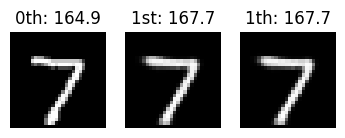

1, 245.2042999267578, 245.2042999267578


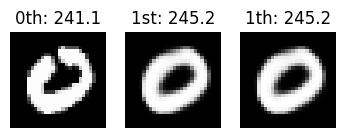

1, 181.47259521484375, 181.47259521484375


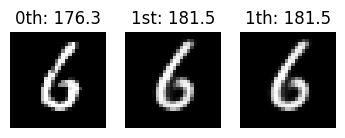

1, 198.79766845703125, 198.79766845703125


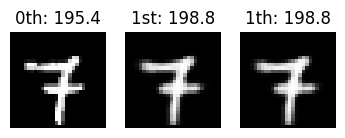

1, 165.39544677734375, 165.39544677734375


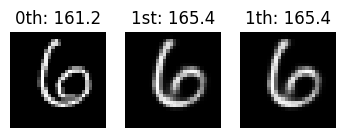

1, 178.09671020507812, 178.09671020507812


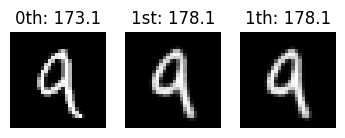

1, 187.24356079101562, 187.24356079101562


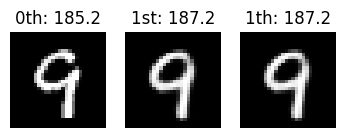

1, 136.10049438476562, 136.10049438476562


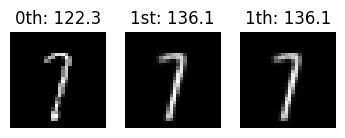

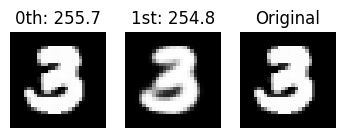

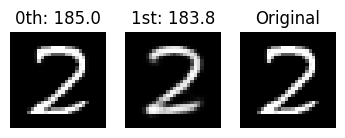

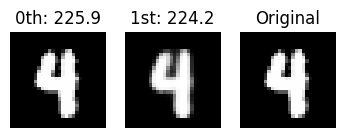

1, 188.04379272460938, 188.04379272460938


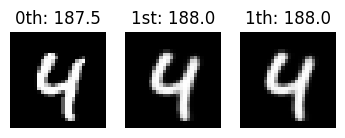

1, 185.92835998535156, 185.92835998535156


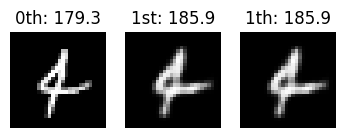

2, 176.13427734375, 175.80203247070312


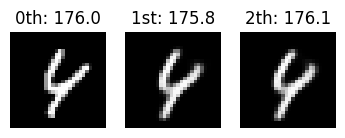

1, 186.39068603515625, 186.39068603515625


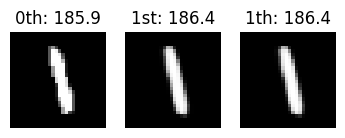

1, 195.299560546875, 195.299560546875


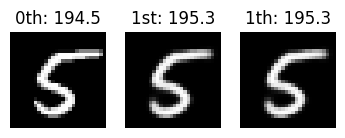

1, 208.4820556640625, 208.4820556640625


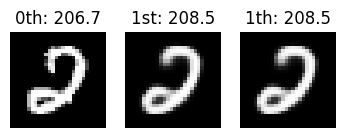

1, 202.05294799804688, 202.05294799804688


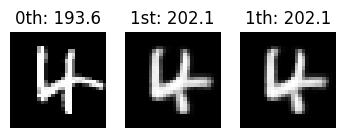

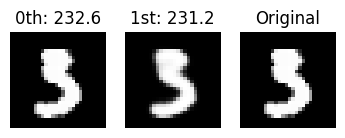

1, 210.0889434814453, 210.0889434814453


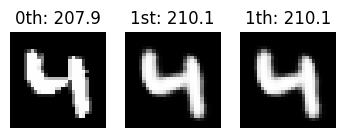

1, 221.96600341796875, 221.96600341796875


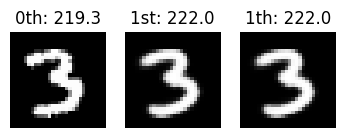

1, 186.75131225585938, 186.75131225585938


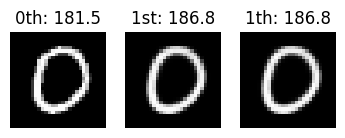

1, 170.15737915039062, 170.15737915039062


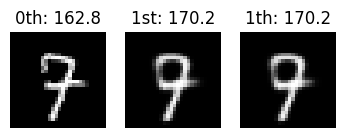

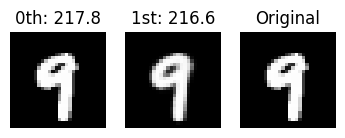

1, 179.16244506835938, 179.16244506835938


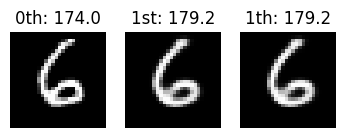

1, 218.85621643066406, 218.85621643066406


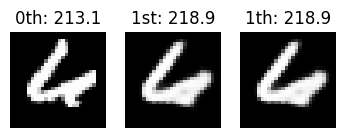

1, 177.80096435546875, 177.80096435546875


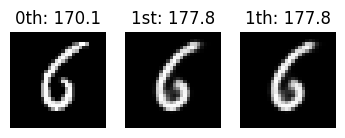

1, 170.33880615234375, 170.33880615234375


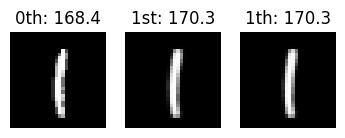

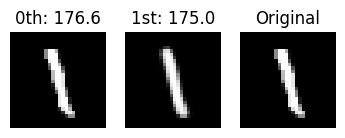

1, 157.55441284179688, 157.55441284179688


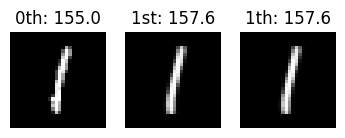

1, 179.16505432128906, 179.16505432128906


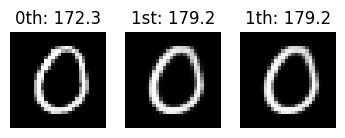

1, 219.7321319580078, 219.7321319580078


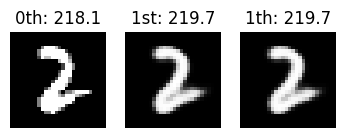

1, 200.71939086914062, 200.71939086914062


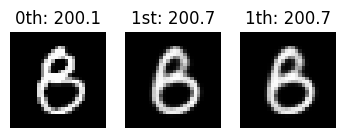

1, 191.6865234375, 191.6865234375


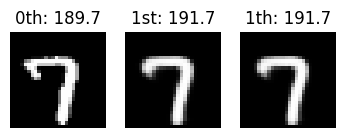

1, 185.66879272460938, 185.66879272460938


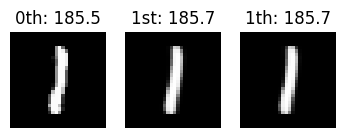

1, 207.70677185058594, 207.70677185058594


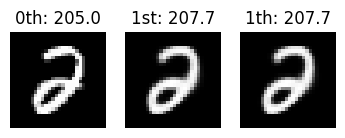

1, 168.8962860107422, 168.8962860107422


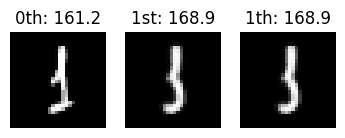

1, 194.97833251953125, 194.97833251953125


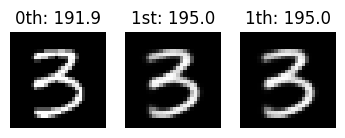

1, 194.3435821533203, 194.3435821533203


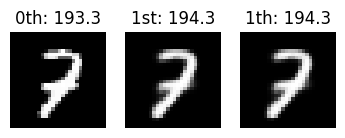

1, 196.6370391845703, 196.6370391845703


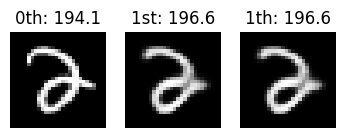

1, 196.193359375, 196.193359375


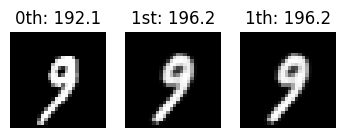

1, 164.36126708984375, 164.36126708984375


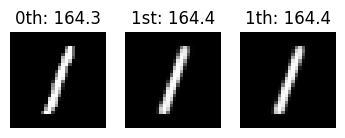

1, 152.6907958984375, 152.6907958984375


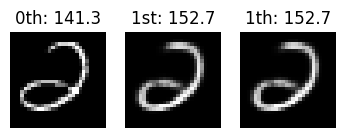

1, 145.4977569580078, 145.4977569580078


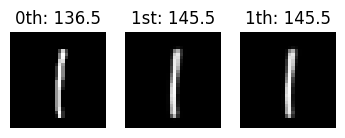

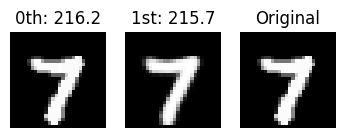

1, 199.38101196289062, 199.38101196289062


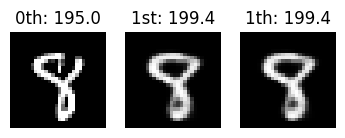

1, 204.78602600097656, 204.78602600097656


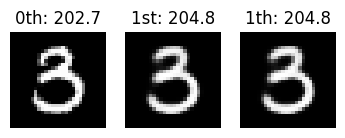

1, 182.86196899414062, 182.86196899414062


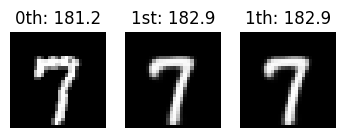

1, 186.2561798095703, 186.2561798095703


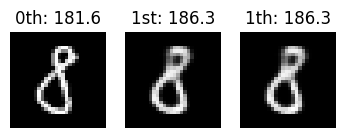

1, 203.56961059570312, 203.56961059570312


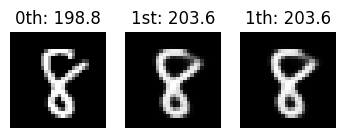

1, 184.45907592773438, 184.45907592773438


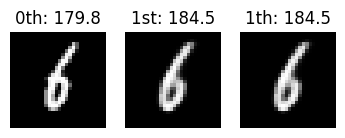

1, 155.4786376953125, 155.4786376953125


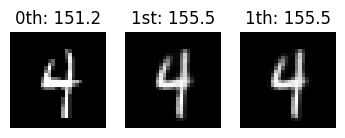

1, 176.763671875, 176.763671875


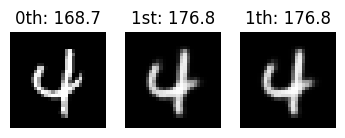

1, 224.41424560546875, 224.41424560546875


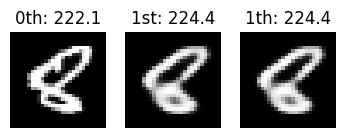

1, 173.7896728515625, 173.7896728515625


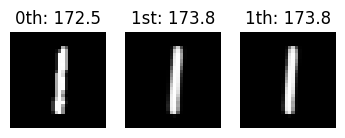

1, 195.10162353515625, 195.10162353515625


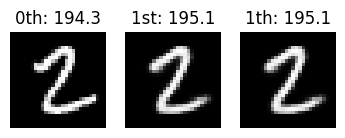

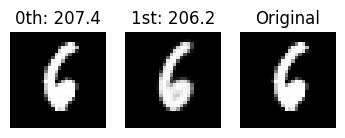

3, 211.66339111328125, 210.58419799804688


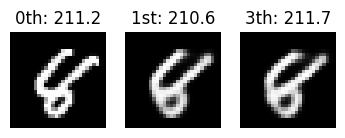

1, 195.25613403320312, 195.25613403320312


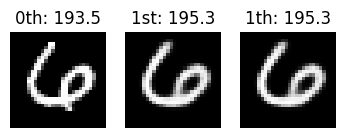

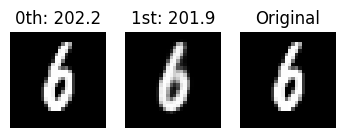

1, 159.0846405029297, 159.0846405029297


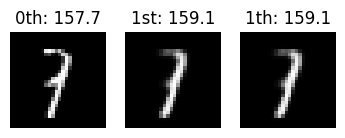

1, 187.37149047851562, 187.37149047851562


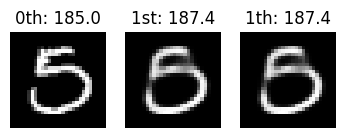

1, 176.19644165039062, 176.19644165039062


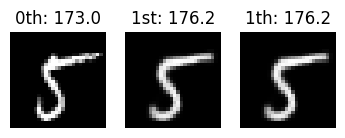

3, 206.28475952148438, 204.02664184570312


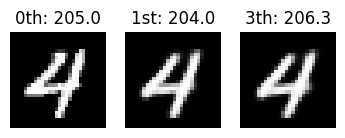

1, 198.96817016601562, 198.96817016601562


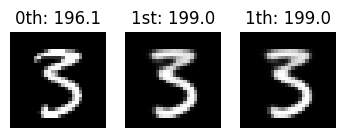

3, 173.60179138183594, 171.96617126464844


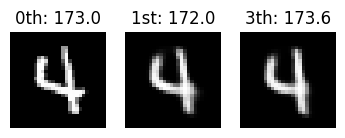

1, 194.05950927734375, 194.05950927734375


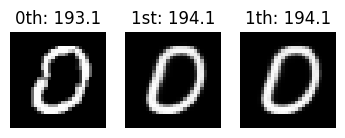

1, 224.28086853027344, 224.28086853027344


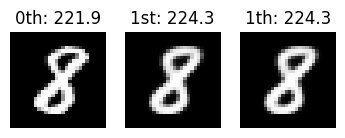

1, 182.554443359375, 182.554443359375


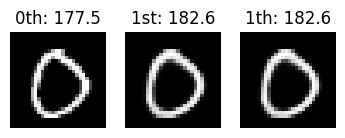

1, 172.83595275878906, 172.83595275878906


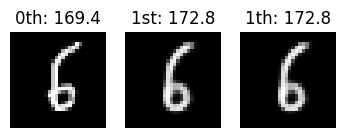

1, 166.19610595703125, 166.19610595703125


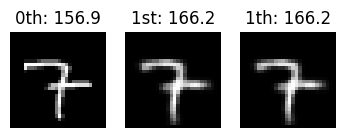

1, 155.57762145996094, 155.57762145996094


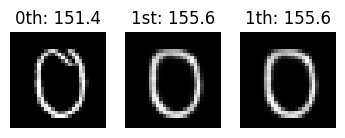

1, 199.04348754882812, 199.04348754882812


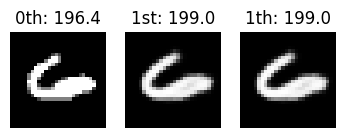

1, 216.8955078125, 216.8955078125


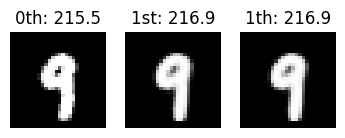

1, 199.1629180908203, 199.1629180908203


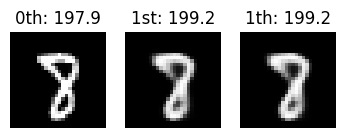

1, 169.78790283203125, 169.78790283203125


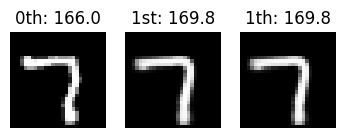

1, 204.2752227783203, 204.2752227783203


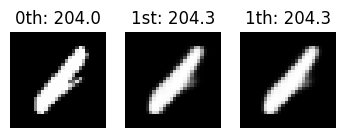

1, 175.0157012939453, 175.0157012939453


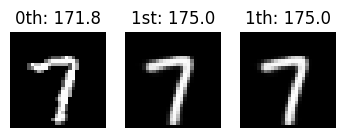

1, 166.39044189453125, 166.39044189453125


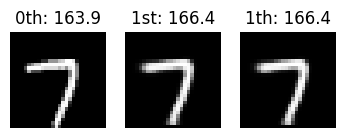

1, 175.04727172851562, 175.04727172851562


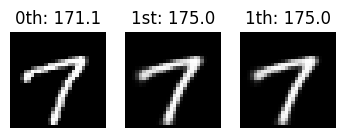

1, 166.95639038085938, 166.95639038085938


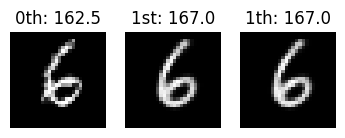

1, 187.5688934326172, 187.5688934326172


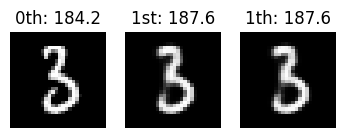

1, 235.98977661132812, 235.98977661132812


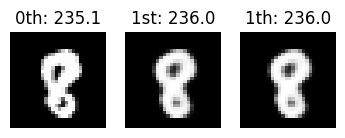

1, 210.42642211914062, 210.42642211914062


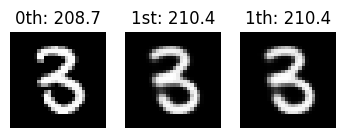

1, 192.86810302734375, 192.86810302734375


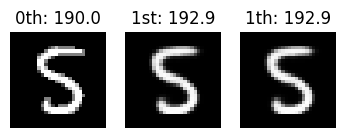

1, 155.6626739501953, 155.6626739501953


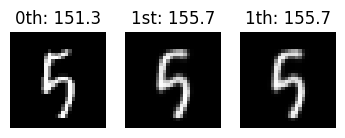

1, 203.93258666992188, 203.93258666992188


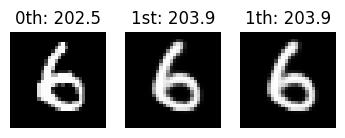

1, 142.72264099121094, 142.72264099121094


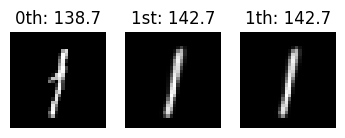

1, 194.40452575683594, 194.40452575683594


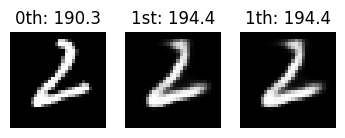

1, 178.843994140625, 178.843994140625


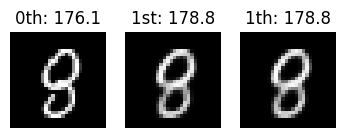

1, 186.92193603515625, 186.92193603515625


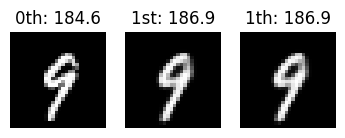

1, 161.48904418945312, 161.48904418945312


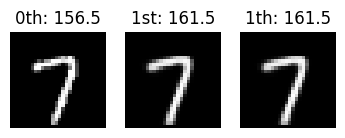

1, 207.12741088867188, 207.12741088867188


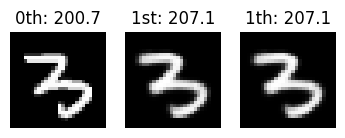

1, 181.06463623046875, 181.06463623046875


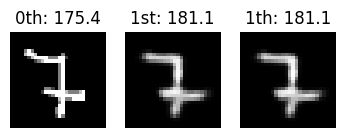

1, 194.0769500732422, 194.0769500732422


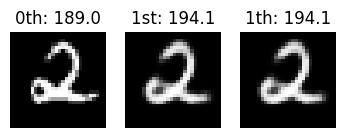

1, 208.5768585205078, 208.5768585205078


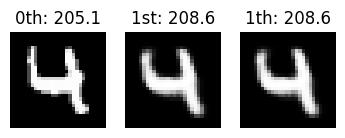

1, 169.72006225585938, 169.72006225585938


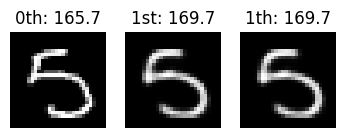

1, 208.84690856933594, 208.84690856933594


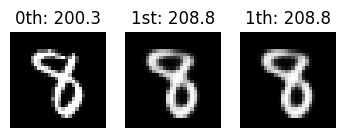

2, 197.99722290039062, 196.89114379882812


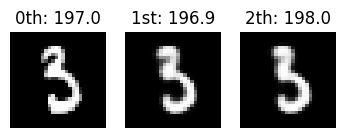

1, 191.17987060546875, 191.17987060546875


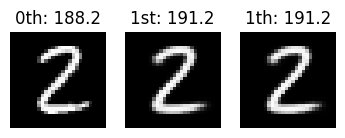

1, 167.75404357910156, 167.75404357910156


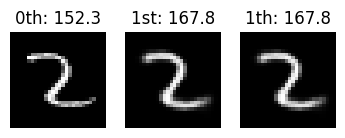

1, 195.0275115966797, 195.0275115966797


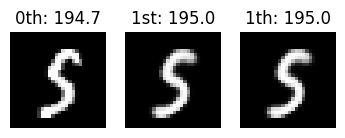

1, 211.3353729248047, 211.3353729248047


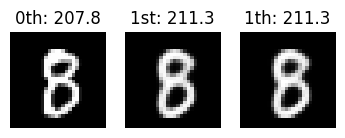

1, 199.4232177734375, 199.4232177734375


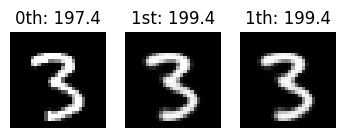

1, 222.9678192138672, 222.9678192138672


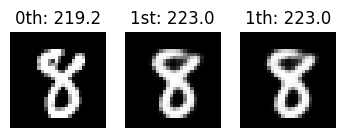

1, 204.93777465820312, 204.93777465820312


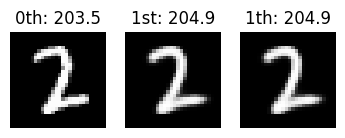

1, 161.87564086914062, 161.87564086914062


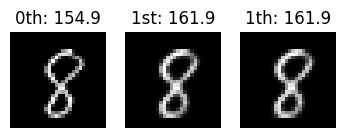

1, 203.46058654785156, 203.46058654785156


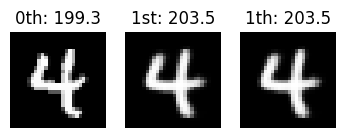

1, 153.2482452392578, 153.2482452392578


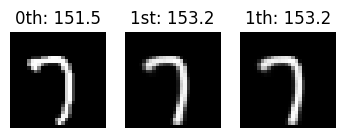

1, 171.7981719970703, 171.7981719970703


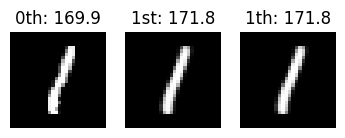

1, 200.82794189453125, 200.82794189453125


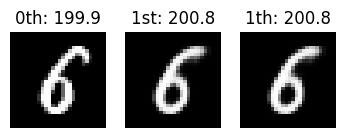

1, 188.4634246826172, 188.4634246826172


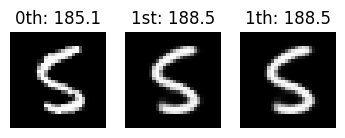

1, 208.19674682617188, 208.19674682617188


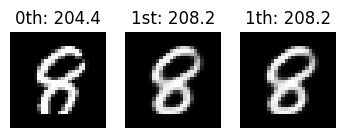

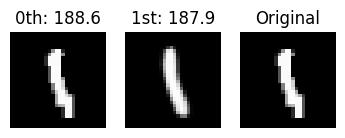

1, 191.03900146484375, 191.03900146484375


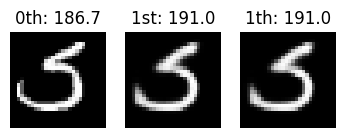

1, 203.2335205078125, 203.2335205078125


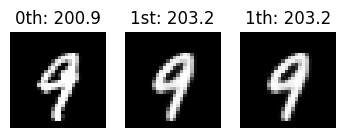

1, 207.07373046875, 207.07373046875


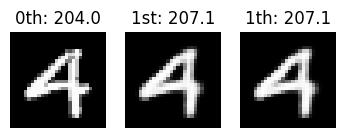

1, 178.08786010742188, 178.08786010742188


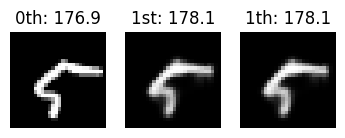

1, 179.27833557128906, 179.27833557128906


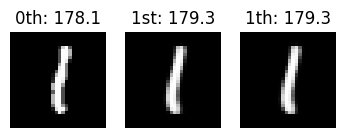

4, 198.42462158203125, 192.84381103515625


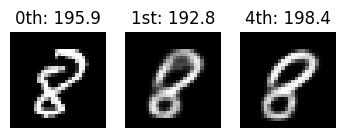

1, 182.19146728515625, 182.19146728515625


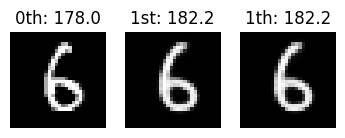

1, 199.0581512451172, 199.0581512451172


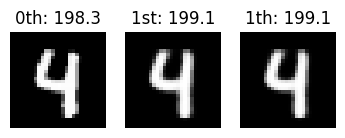

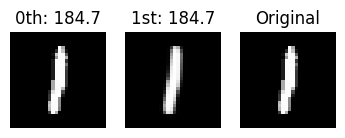

1, 188.70779418945312, 188.70779418945312


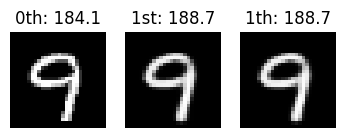

1, 189.54031372070312, 189.54031372070312


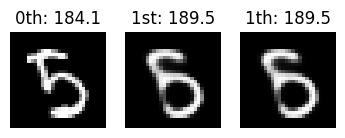

1, 191.88018798828125, 191.88018798828125


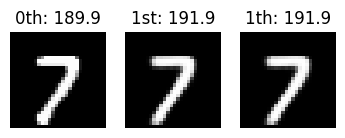

1, 198.43370056152344, 198.43370056152344


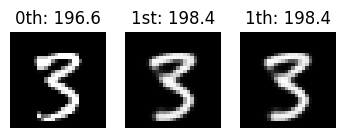

1, 182.63916015625, 182.63916015625


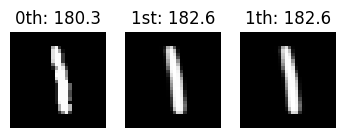

1, 217.71978759765625, 217.71978759765625


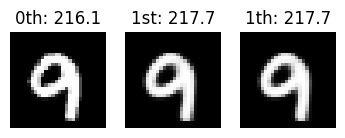

1, 138.21597290039062, 138.21597290039062


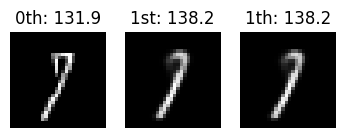

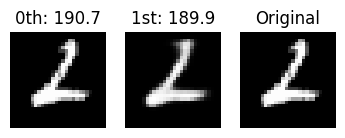

1, 162.98428344726562, 162.98428344726562


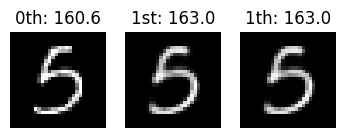

1, 187.54815673828125, 187.54815673828125


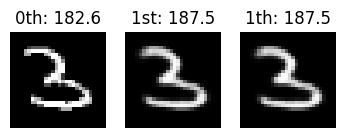

1, 215.00238037109375, 215.00238037109375


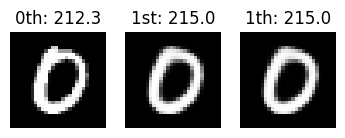

1, 174.89181518554688, 174.89181518554688


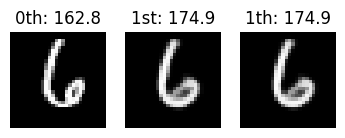

1, 189.81982421875, 189.81982421875


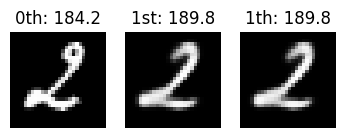

1, 170.12391662597656, 170.12391662597656


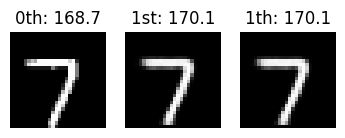

1, 158.30197143554688, 158.30197143554688


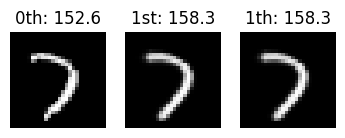

1, 208.09483337402344, 208.09483337402344


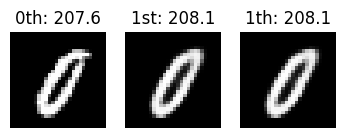

1, 169.06805419921875, 169.06805419921875


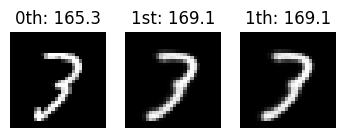

1, 190.8536376953125, 190.8536376953125


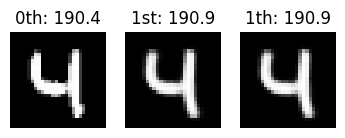

1, 208.18026733398438, 208.18026733398438


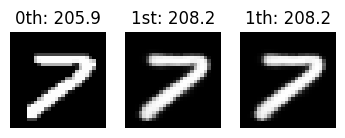

1, 202.1984405517578, 202.1984405517578


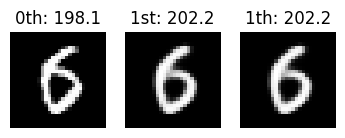

1, 184.00820922851562, 184.00820922851562


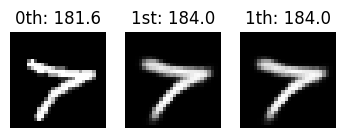

1, 216.88919067382812, 216.88919067382812


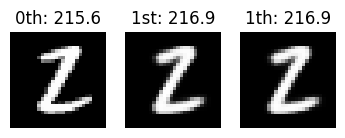

1, 163.00274658203125, 163.00274658203125


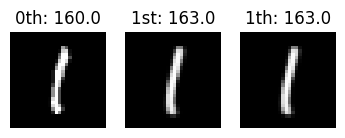

1, 199.11294555664062, 199.11294555664062


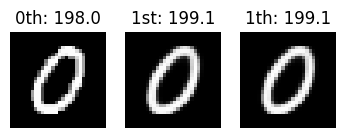

1, 203.36221313476562, 203.36221313476562


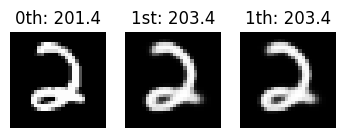

1, 185.97225952148438, 185.97225952148438


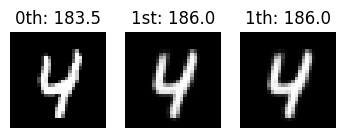

1, 165.138916015625, 165.138916015625


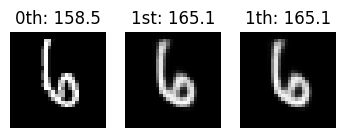

1, 170.43511962890625, 170.43511962890625


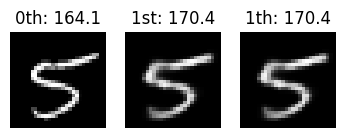

1, 202.1059112548828, 202.1059112548828


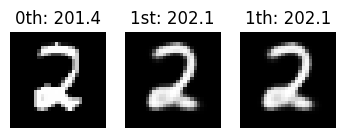

1, 168.94088745117188, 168.94088745117188


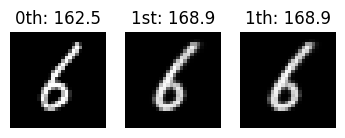

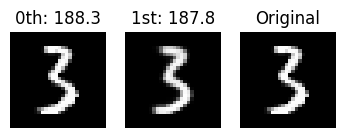

1, 185.80563354492188, 185.80563354492188


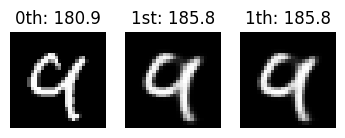

1, 175.03561401367188, 175.03561401367188


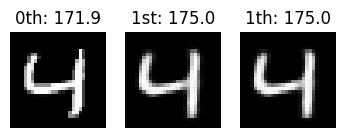

1, 191.41683959960938, 191.41683959960938


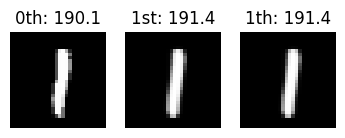

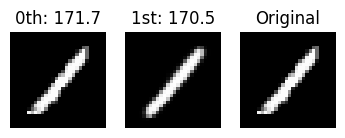

1, 196.14852905273438, 196.14852905273438


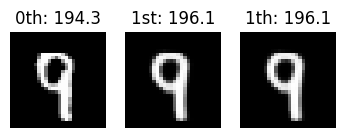

1, 232.1092071533203, 232.1092071533203


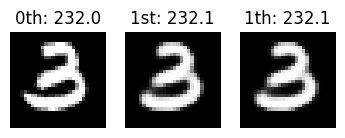

1, 186.26551818847656, 186.26551818847656


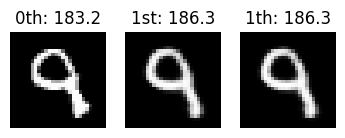

1, 179.93173217773438, 179.93173217773438


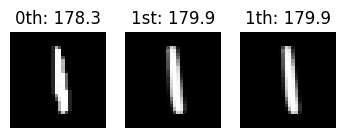

1, 141.36598205566406, 141.36598205566406


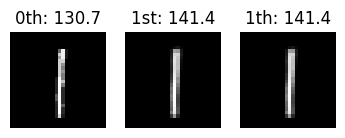

1, 206.2883758544922, 206.2883758544922


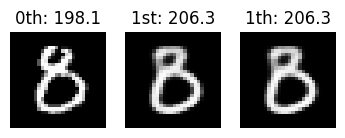

1, 225.29153442382812, 225.29153442382812


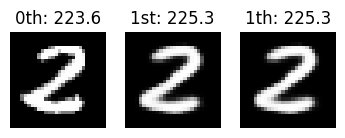

1, 202.40301513671875, 202.40301513671875


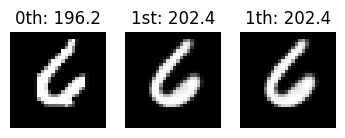

1, 213.30490112304688, 213.30490112304688


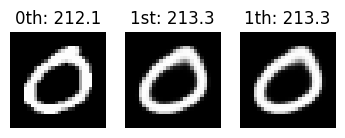

1, 184.58180236816406, 184.58180236816406


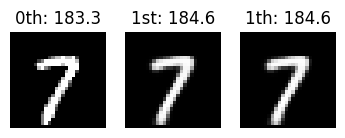

1, 180.4736328125, 180.4736328125


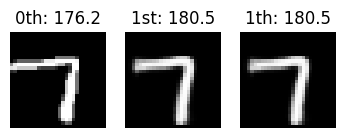

1, 205.55841064453125, 205.55841064453125


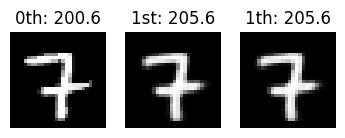

1, 191.686279296875, 191.686279296875


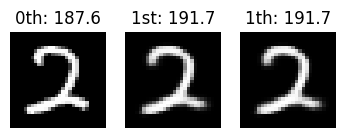

1, 216.24261474609375, 216.24261474609375


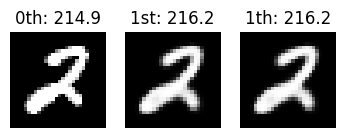

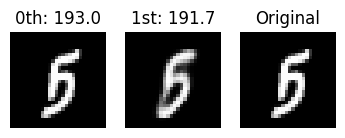

1, 206.86277770996094, 206.86277770996094


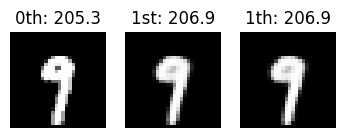

1, 184.51364135742188, 184.51364135742188


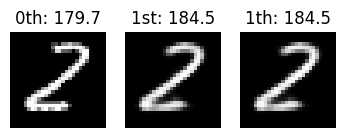

1, 199.34210205078125, 199.34210205078125


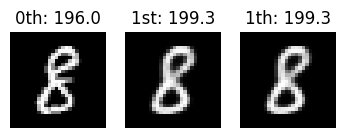

1, 174.89776611328125, 174.89776611328125


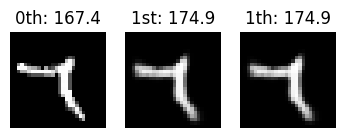

1, 224.49319458007812, 224.49319458007812


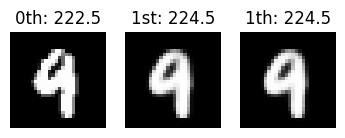

4, 161.2769317626953, 160.02621459960938


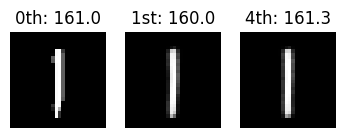

1, 180.9481964111328, 180.9481964111328


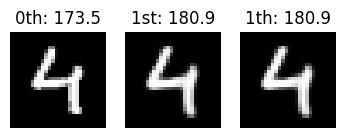

1, 161.8692626953125, 161.8692626953125


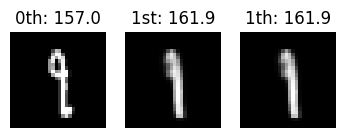

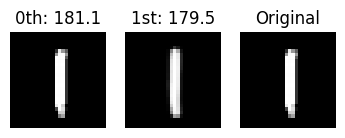

1, 198.17709350585938, 198.17709350585938


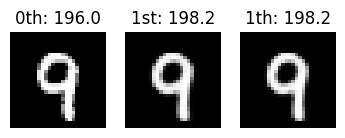

1, 191.2547149658203, 191.2547149658203


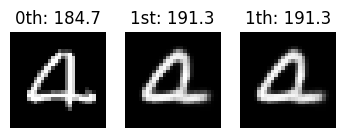

1, 201.81988525390625, 201.81988525390625


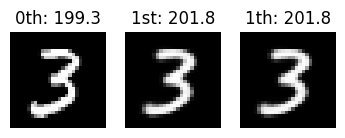

1, 186.9268798828125, 186.9268798828125


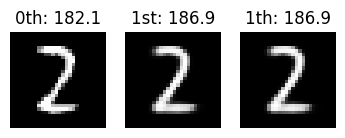

1, 186.28805541992188, 186.28805541992188


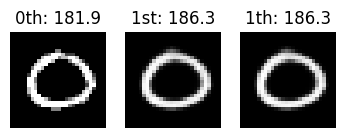

1, 185.14419555664062, 185.14419555664062


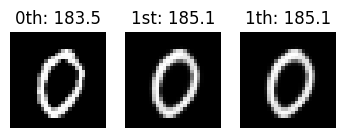

1, 196.53451538085938, 196.53451538085938


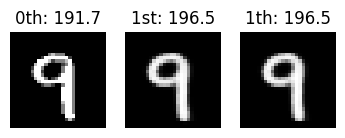

1, 188.90597534179688, 188.90597534179688


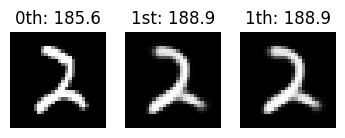

1, 220.61318969726562, 220.61318969726562


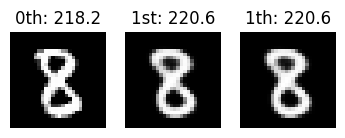

1, 210.59671020507812, 210.59671020507812


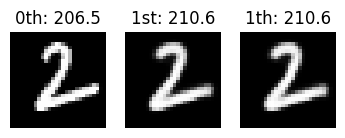

1, 184.0178680419922, 184.0178680419922


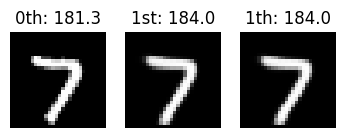

1, 199.98190307617188, 199.98190307617188


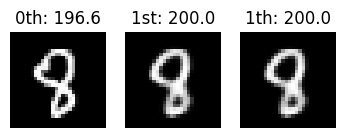

1, 193.73367309570312, 193.73367309570312


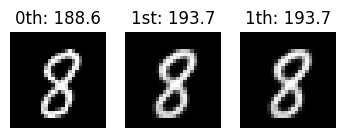

1, 234.26904296875, 234.26904296875


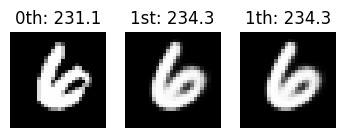

1, 175.29473876953125, 175.29473876953125


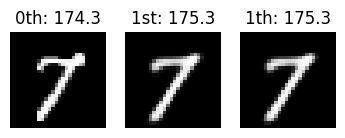

1, 212.301513671875, 212.301513671875


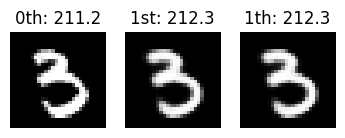

3, 176.53321838378906, 172.32882690429688


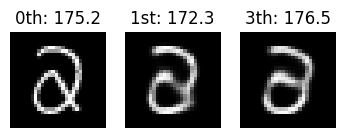

1, 203.55624389648438, 203.55624389648438


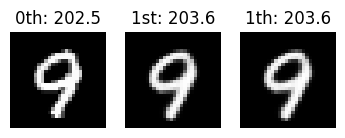

1, 187.83099365234375, 187.83099365234375


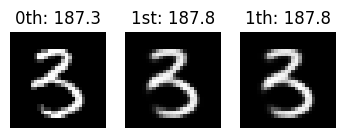

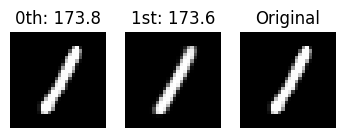

1, 191.80543518066406, 191.80543518066406


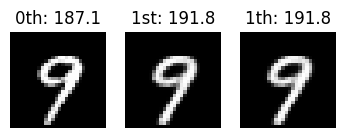

1, 189.27899169921875, 189.27899169921875


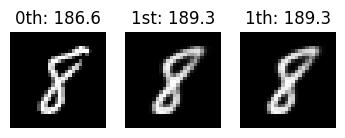

1, 211.6683349609375, 211.6683349609375


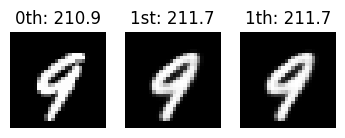

1, 227.43893432617188, 227.43893432617188


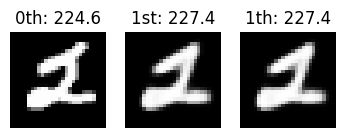

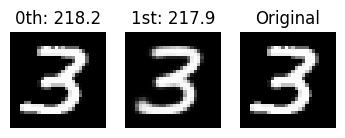

1, 180.33316040039062, 180.33316040039062


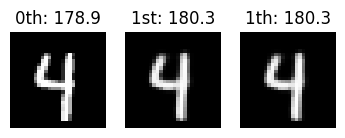

1, 169.91793823242188, 169.91793823242188


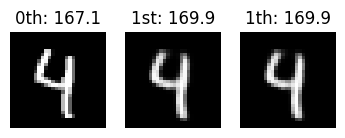

1, 196.80511474609375, 196.80511474609375


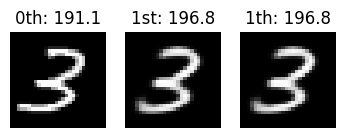

1, 199.74032592773438, 199.74032592773438


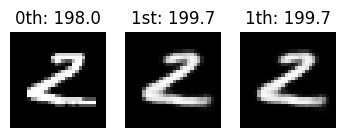

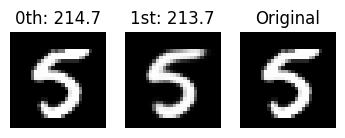

1, 208.1171417236328, 208.1171417236328


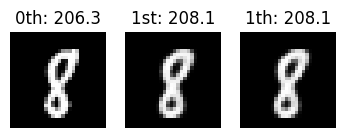

1, 204.9219970703125, 204.9219970703125


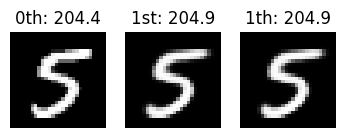

1, 177.34649658203125, 177.34649658203125


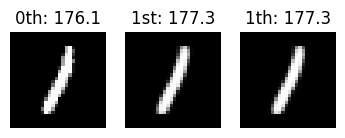

1, 201.82647705078125, 201.82647705078125


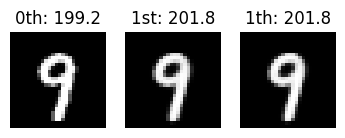

1, 178.5404815673828, 178.5404815673828


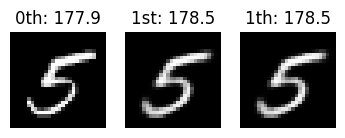

1, 197.2061004638672, 197.2061004638672


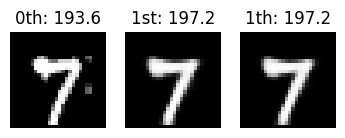

1, 213.5889892578125, 213.5889892578125


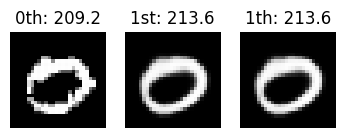

1, 222.0975341796875, 222.0975341796875


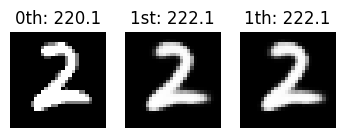

1, 206.18788146972656, 206.18788146972656


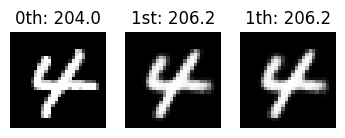

1, 197.69451904296875, 197.69451904296875


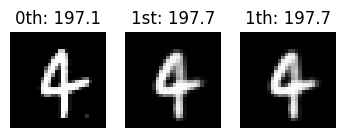

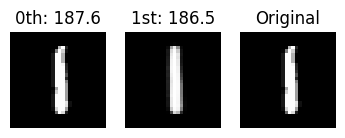

1, 209.01959228515625, 209.01959228515625


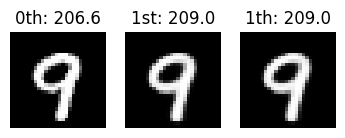

1, 191.34896850585938, 191.34896850585938


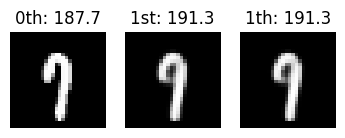

1, 209.76950073242188, 209.76950073242188


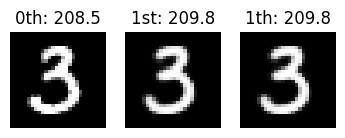

4, 221.26296997070312, 221.07611083984375


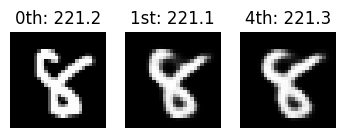

1, 207.0155792236328, 207.0155792236328


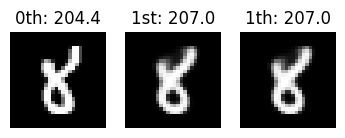

1, 194.57777404785156, 194.57777404785156


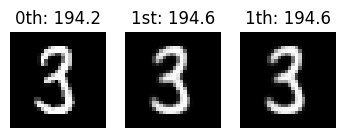

1, 180.86082458496094, 180.86082458496094


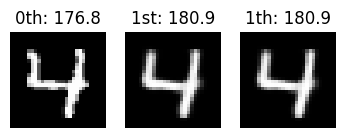

2, 226.3543243408203, 225.9480743408203


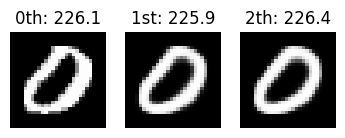

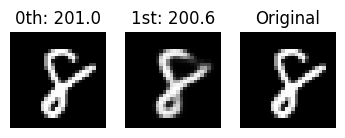

1, 199.33236694335938, 199.33236694335938


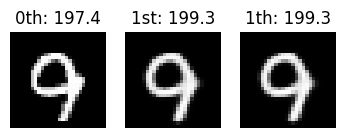

1, 185.67764282226562, 185.67764282226562


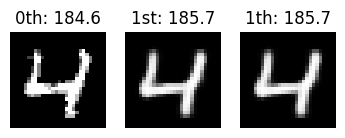

1, 210.024658203125, 210.024658203125


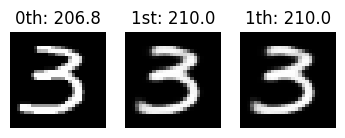

1, 206.87371826171875, 206.87371826171875


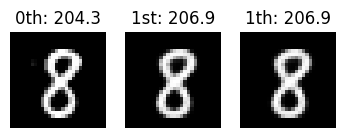

1, 180.8954315185547, 180.8954315185547


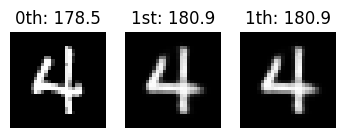

1, 186.40670776367188, 186.40670776367188


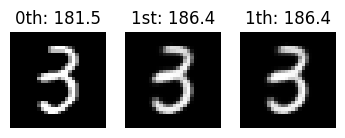

1, 229.5320281982422, 229.5320281982422


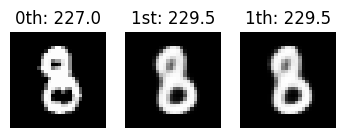

3, 174.04391479492188, 172.66390991210938


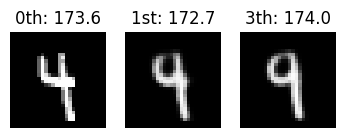

1, 191.17092895507812, 191.17092895507812


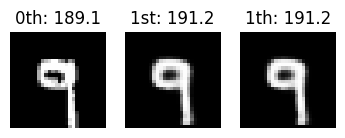

1, 187.37493896484375, 187.37493896484375


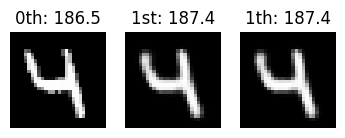

1, 147.6173095703125, 147.6173095703125


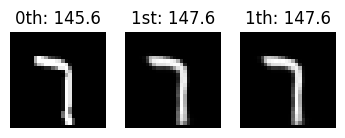

1, 248.26571655273438, 248.26571655273438


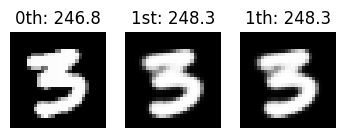

1, 223.11288452148438, 223.11288452148438


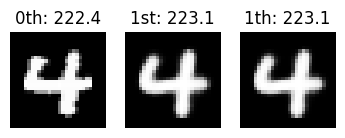

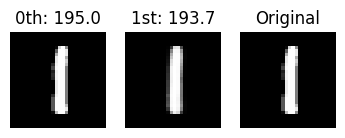

1, 244.44546508789062, 244.44546508789062


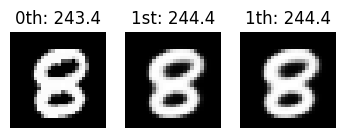

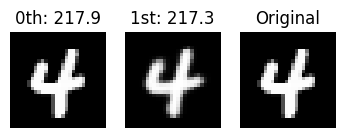

1, 196.73370361328125, 196.73370361328125


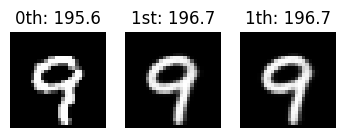

1, 206.4198455810547, 206.4198455810547


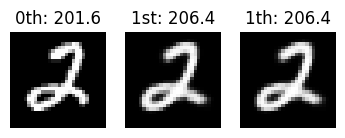

1, 215.54986572265625, 215.54986572265625


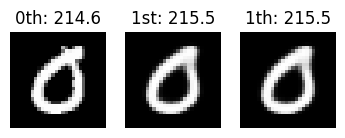

1, 214.0074920654297, 214.0074920654297


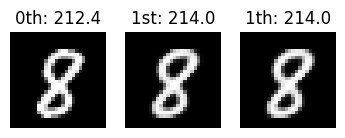

1, 190.1376953125, 190.1376953125


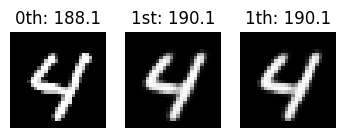

1, 210.4337158203125, 210.4337158203125


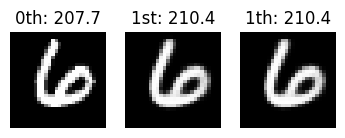

1, 188.9552001953125, 188.9552001953125


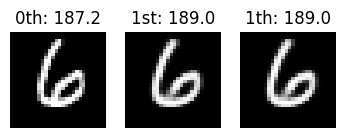

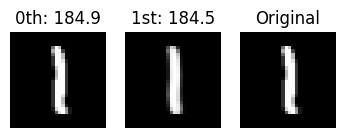

1, 197.6968994140625, 197.6968994140625


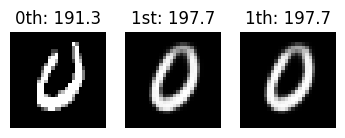

1, 227.2933807373047, 227.2933807373047


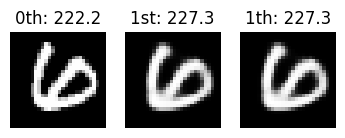

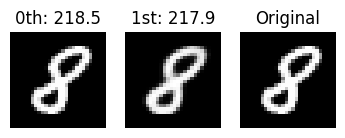

1, 192.67282104492188, 192.67282104492188


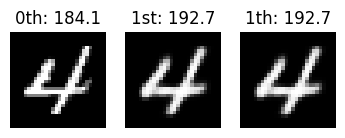

1, 195.6910858154297, 195.6910858154297


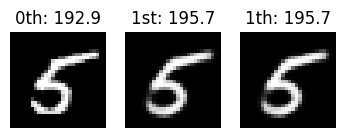

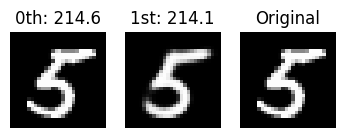

1, 193.32485961914062, 193.32485961914062


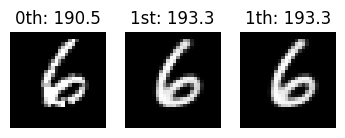

1, 156.28530883789062, 156.28530883789062


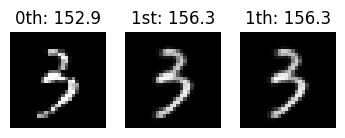

1, 159.5404815673828, 159.5404815673828


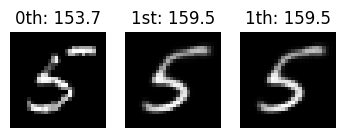

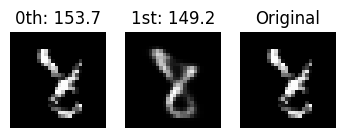

1, 189.94674682617188, 189.94674682617188


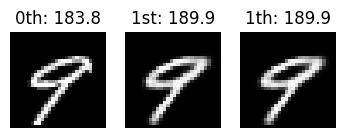

1, 212.61154174804688, 212.61154174804688


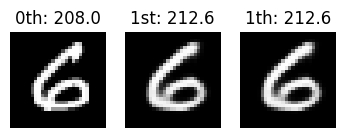

1, 173.025146484375, 173.025146484375


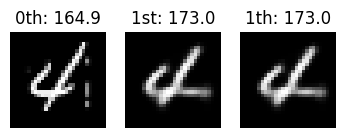

1, 193.56600952148438, 193.56600952148438


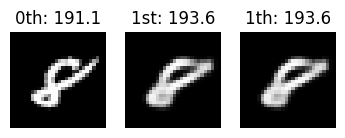

1, 219.21934509277344, 219.21934509277344


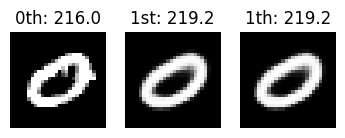

4, 168.19696044921875, 166.15780639648438


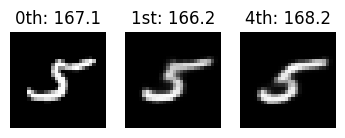

1, 190.79293823242188, 190.79293823242188


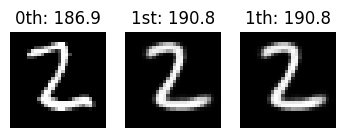

1, 186.54779052734375, 186.54779052734375


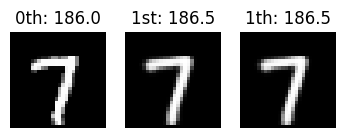

1, 215.6057586669922, 215.6057586669922


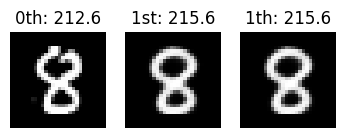

1, 206.72067260742188, 206.72067260742188


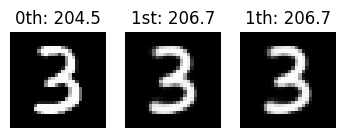

1, 171.0617218017578, 171.0617218017578


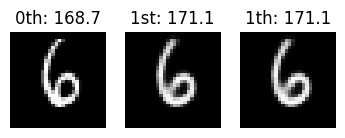

1, 199.21717834472656, 199.21717834472656


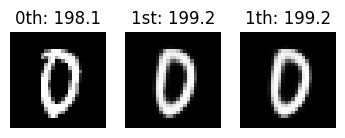

1, 207.89967346191406, 207.89967346191406


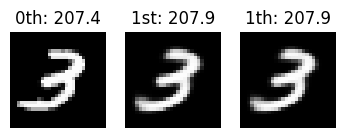

3, 221.33834838867188, 219.28919982910156


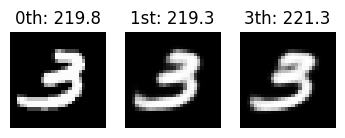

1, 152.8004608154297, 152.8004608154297


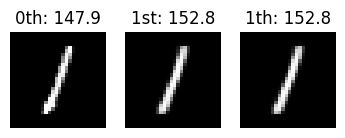

1, 192.8119354248047, 192.8119354248047


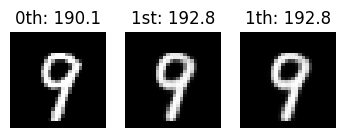

1, 233.29830932617188, 233.29830932617188


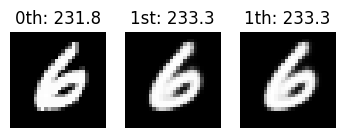

1, 232.11070251464844, 232.11070251464844


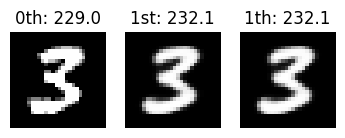

1, 199.36907958984375, 199.36907958984375


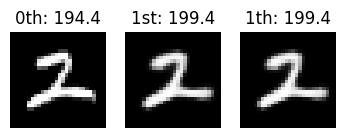

1, 200.06362915039062, 200.06362915039062


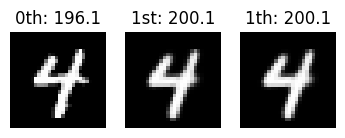

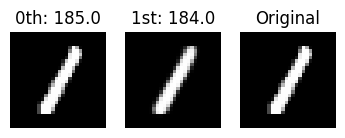

1, 182.80532836914062, 182.80532836914062


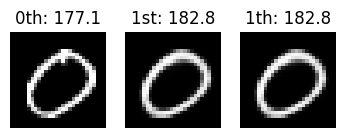

1, 206.50096130371094, 206.50096130371094


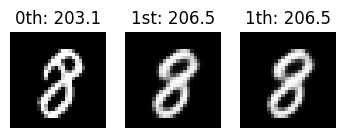

1, 192.8922882080078, 192.8922882080078


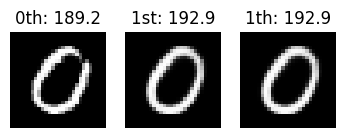

1, 214.79010009765625, 214.79010009765625


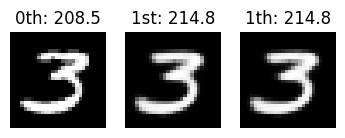

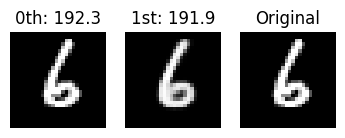

1, 189.56277465820312, 189.56277465820312


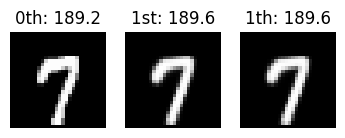

1, 190.80670166015625, 190.80670166015625


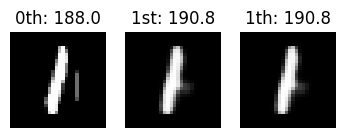

1, 203.7093963623047, 203.7093963623047


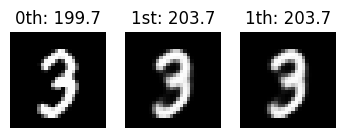

1, 194.80882263183594, 194.80882263183594


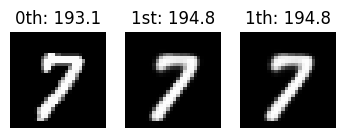

4, 192.13082885742188, 188.74798583984375


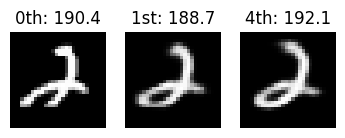

1, 171.73049926757812, 171.73049926757812


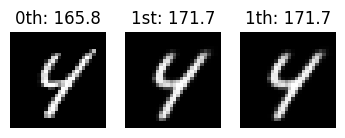

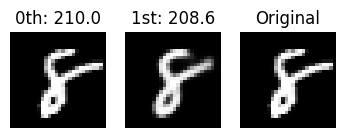

1, 194.65821838378906, 194.65821838378906


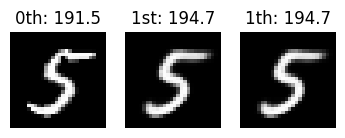

1, 206.87771606445312, 206.87771606445312


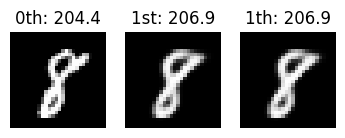

1, 203.03640747070312, 203.03640747070312


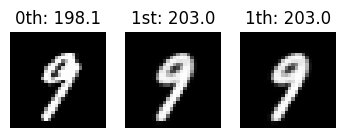

1, 198.24539184570312, 198.24539184570312


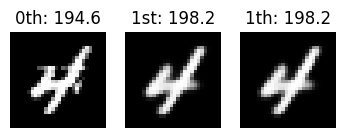

1, 207.8348846435547, 207.8348846435547


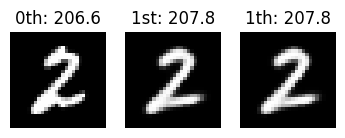

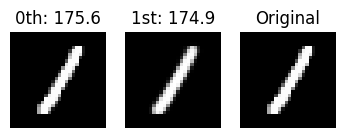

1, 199.86521911621094, 199.86521911621094


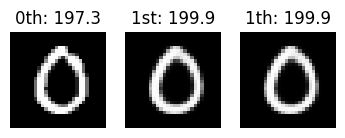

3, 179.55157470703125, 179.07464599609375


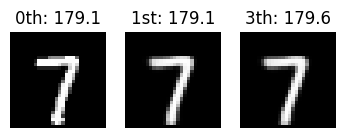

1, 175.12864685058594, 175.12864685058594


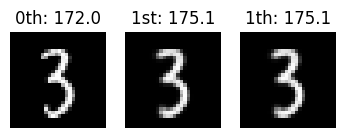

1, 166.69696044921875, 166.69696044921875


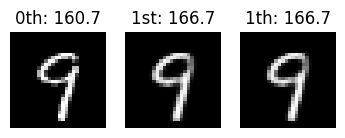

1, 170.8564453125, 170.8564453125


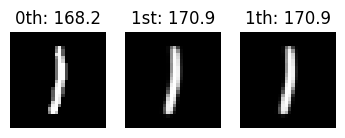

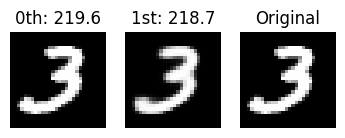

1, 222.42579650878906, 222.42579650878906


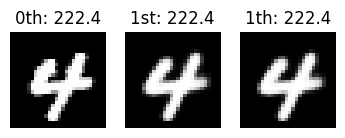

1, 234.25701904296875, 234.25701904296875


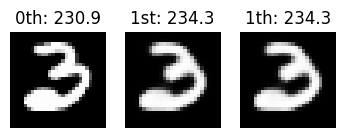

1, 230.1138916015625, 230.1138916015625


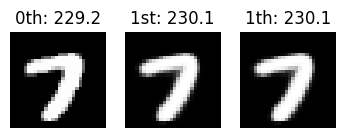

1, 232.5023193359375, 232.5023193359375


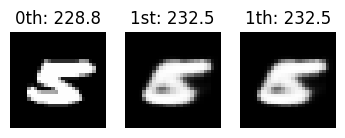

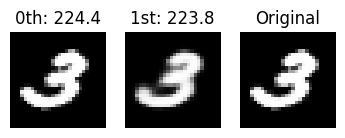

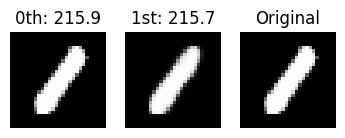

1, 259.5374755859375, 259.5374755859375


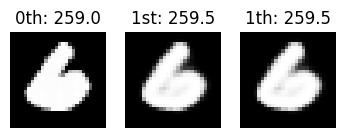

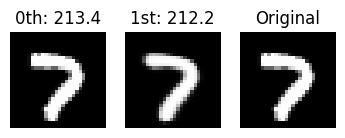

1, 219.42820739746094, 219.42820739746094


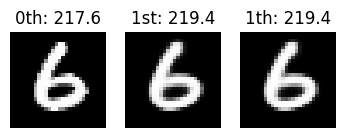

1, 210.1564483642578, 210.1564483642578


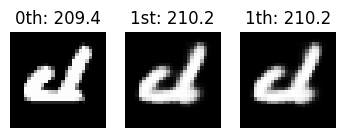

1, 221.32797241210938, 221.32797241210938


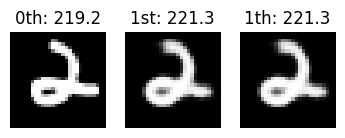

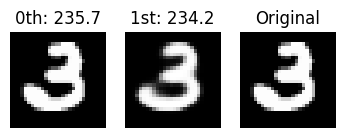

1, 236.3565673828125, 236.3565673828125


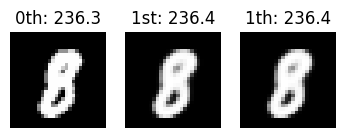

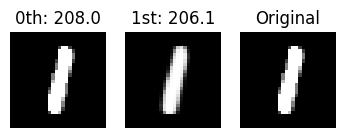

1, 223.09156799316406, 223.09156799316406


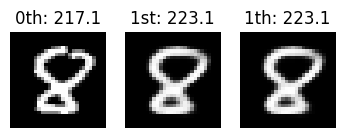

1, 198.61846923828125, 198.61846923828125


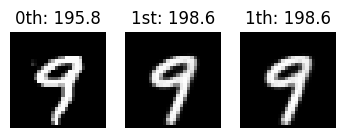

1, 190.9259033203125, 190.9259033203125


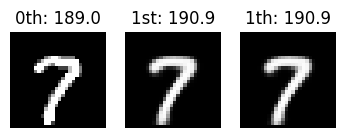

1, 228.01954650878906, 228.01954650878906


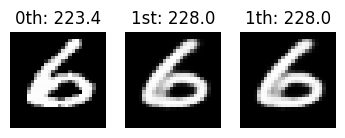

1, 196.30313110351562, 196.30313110351562


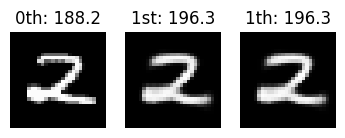

1, 201.58273315429688, 201.58273315429688


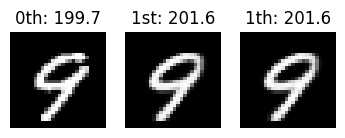

1, 163.2144775390625, 163.2144775390625


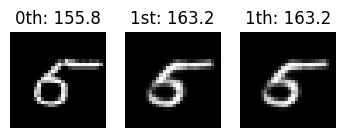

2, 228.8379364013672, 228.22921752929688


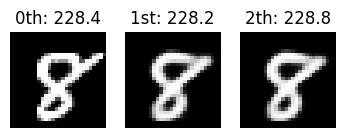

1, 200.0973663330078, 200.0973663330078


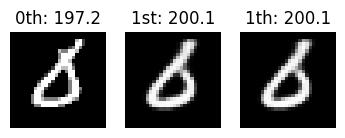

1, 201.32864379882812, 201.32864379882812


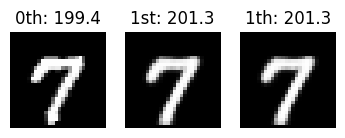

1, 219.0582275390625, 219.0582275390625


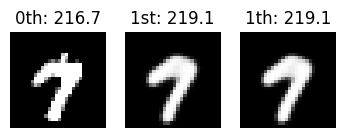

1, 185.61538696289062, 185.61538696289062


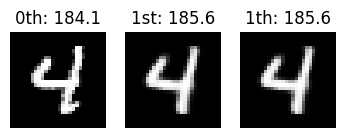

1, 180.23484802246094, 180.23484802246094


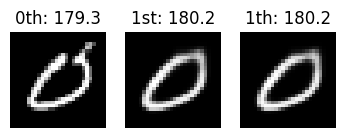

1, 205.44354248046875, 205.44354248046875


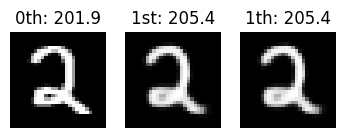

2, 220.54061889648438, 220.1242218017578


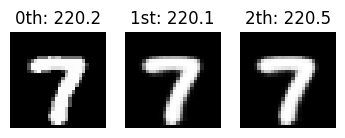

1, 209.56005859375, 209.56005859375


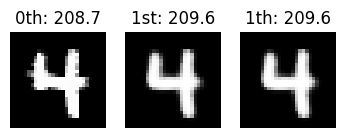

1, 206.0697021484375, 206.0697021484375


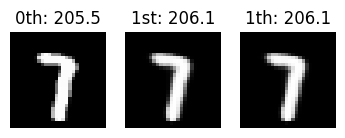

1, 208.03256225585938, 208.03256225585938


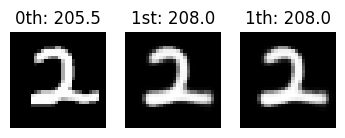

1, 187.40444946289062, 187.40444946289062


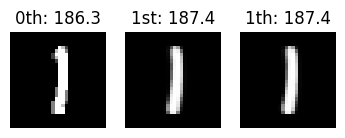

1, 183.04623413085938, 183.04623413085938


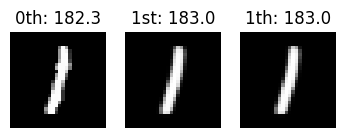

1, 210.9568634033203, 210.9568634033203


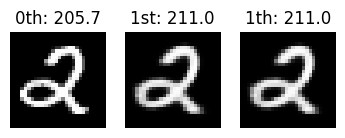

1, 161.78042602539062, 161.78042602539062


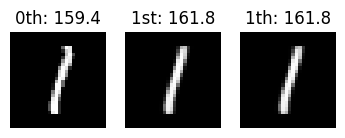

1, 201.76580810546875, 201.76580810546875


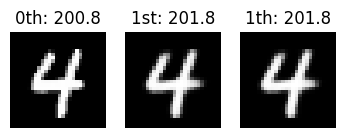

1, 203.47547912597656, 203.47547912597656


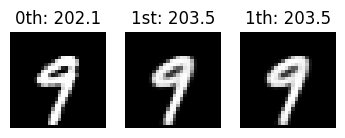

1, 224.23269653320312, 224.23269653320312


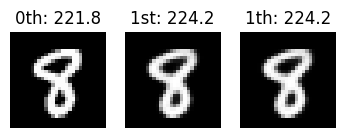

1, 220.22930908203125, 220.22930908203125


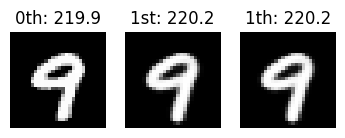

1, 212.13458251953125, 212.13458251953125


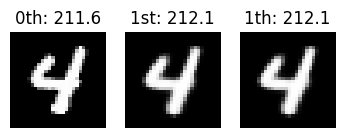

1, 220.38250732421875, 220.38250732421875


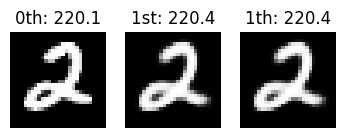

1, 182.1170196533203, 182.1170196533203


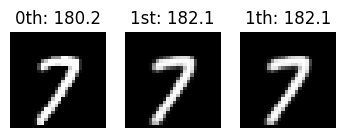

3, 183.13104248046875, 182.68629455566406


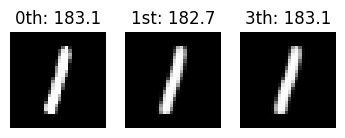

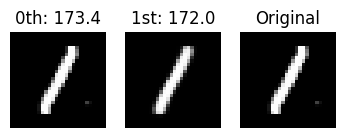

4, 196.55825805664062, 194.82765197753906


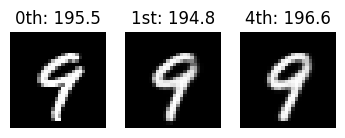

1, 200.18748474121094, 200.18748474121094


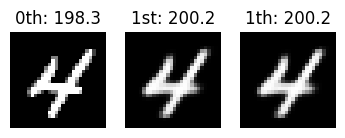

1, 203.55889892578125, 203.55889892578125


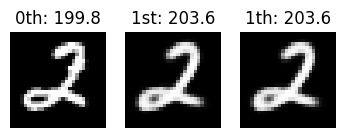

1, 207.3800506591797, 207.3800506591797


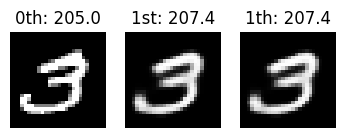

1, 191.4863739013672, 191.4863739013672


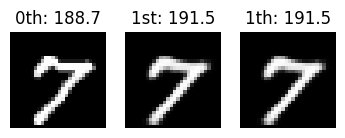

1, 163.47589111328125, 163.47589111328125


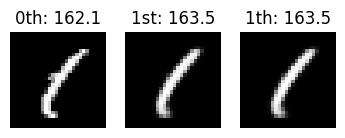

1, 204.19485473632812, 204.19485473632812


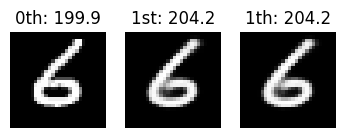

1, 237.90643310546875, 237.90643310546875


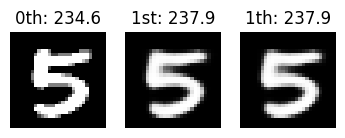

1, 220.0715789794922, 220.0715789794922


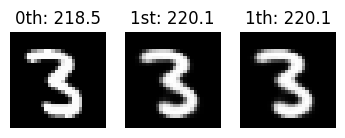

1, 223.026611328125, 223.026611328125


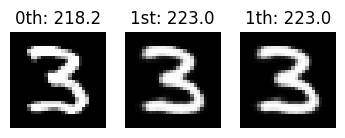

1, 224.18533325195312, 224.18533325195312


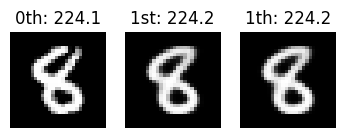

1, 222.55960083007812, 222.55960083007812


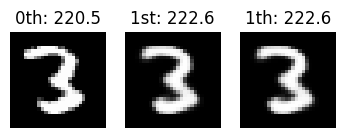

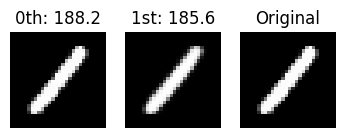

1, 231.92337036132812, 231.92337036132812


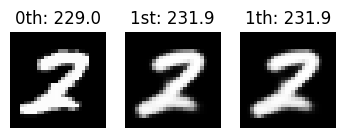

1, 208.83770751953125, 208.83770751953125


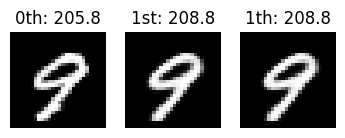

1, 177.21221923828125, 177.21221923828125


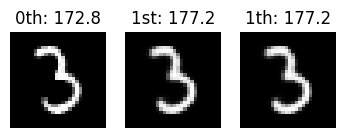

4, 178.92105102539062, 175.25933837890625


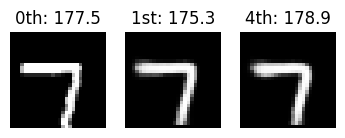

1, 202.09625244140625, 202.09625244140625


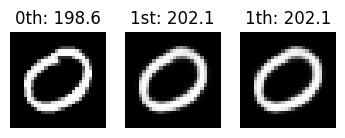

1, 152.46449279785156, 152.46449279785156


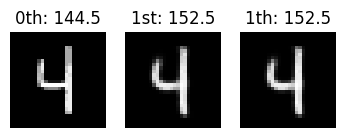

3, 231.67843627929688, 231.07406616210938


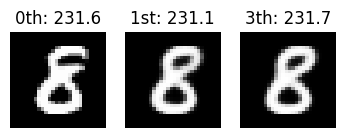

1, 210.34381103515625, 210.34381103515625


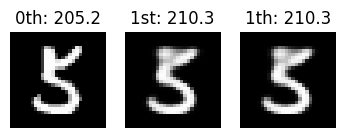

1, 202.16165161132812, 202.16165161132812


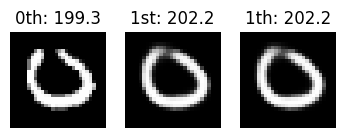

1, 202.73956298828125, 202.73956298828125


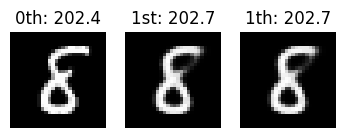

1, 214.085693359375, 214.085693359375


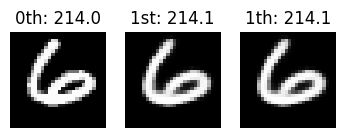

2, 219.13937377929688, 218.42535400390625


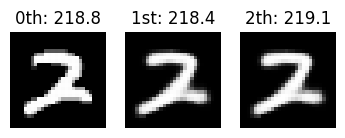

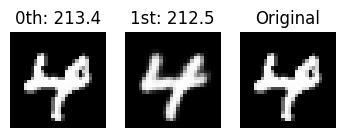

1, 212.2117919921875, 212.2117919921875


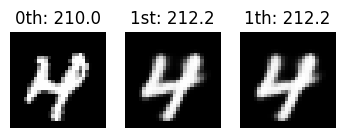

2, 224.7948760986328, 223.92794799804688


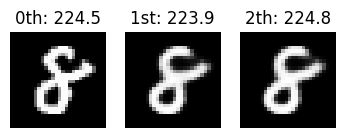

1, 181.61123657226562, 181.61123657226562


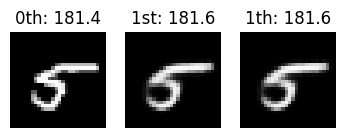

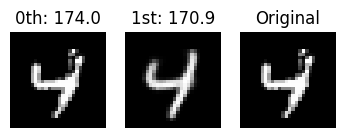

1, 194.799072265625, 194.799072265625


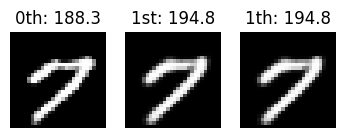

1, 165.54446411132812, 165.54446411132812


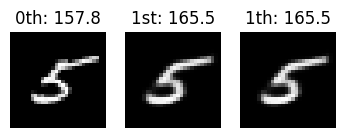

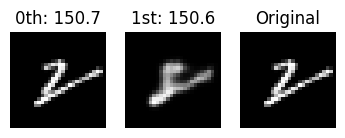

1, 149.2147216796875, 149.2147216796875


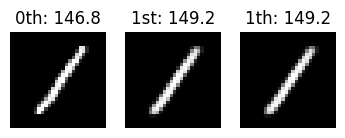

1, 223.4977569580078, 223.4977569580078


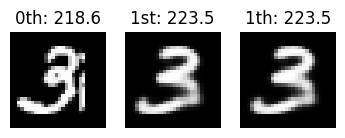

1, 218.10948181152344, 218.10948181152344


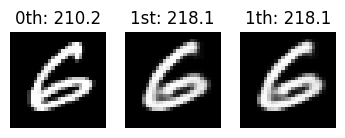

1, 198.16864013671875, 198.16864013671875


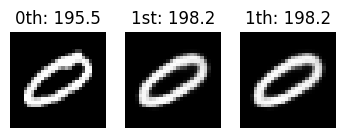

1, 187.6536407470703, 187.6536407470703


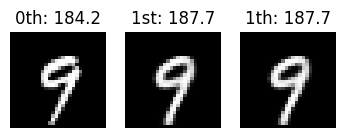

1, 230.6102294921875, 230.6102294921875


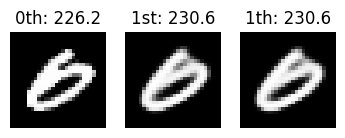

1, 183.97393798828125, 183.97393798828125


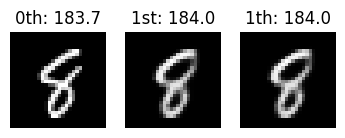

1, 196.53585815429688, 196.53585815429688


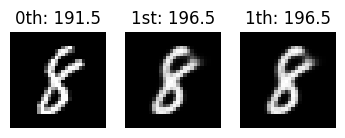

1, 186.76580810546875, 186.76580810546875


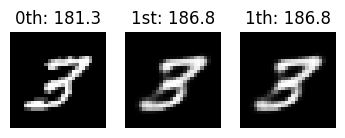

1, 152.79913330078125, 152.79913330078125


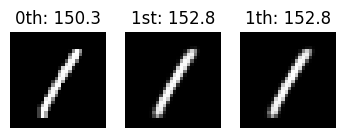

1, 178.37081909179688, 178.37081909179688


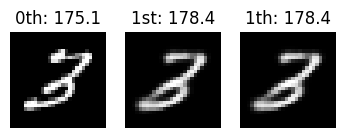

In [9]:
data_loader = DataLoader(mnist_test, batch_size = 25)
sampling = 5

for data, data_label in data_loader:
    fig, axes = plt.subplots(1, 3, figsize=(6*0.7, 2))
    image = data.to(device)
    values = evaluator(image.reshape(image.size(0),-1))[0]
    image_origin = image[0][0].cpu()
    value_origin = torch.log(values+1e-5).sum().item()
    axes[0].imshow(image_origin, cmap='gray')
    axes[0].set_title(f'0th: {value_origin:.1f}')
    axes[0].axis('off')  # Turn off axis numbers

    recon_x = image
    count = 0
    for i in range(1, sampling):
        recon_x, mean, log_var = model(recon_x, do_reparam = False)
        image = recon_x[0].detach()
        values = evaluator(image.reshape(image.size(0),-1))[0]
        value_image = torch.log(values+1e-5).sum().item()

        if i == 1:
            value = value_image
            axes[1].imshow(image[0].cpu(), cmap='gray')
            axes[1].set_title(f'1st: {value_image:.1f}')
            axes[1].axis('off')  # Turn off axis numbers

        if value_image >= value and value_image > value_origin:
            count += 1
            print(f"{i}, {value_image}, {value}")
            value = value_image
            axes[2].imshow(image[0].cpu(), cmap='gray')
            axes[2].set_title(f'{i}th: {value_image:.1f}')
            axes[2].axis('off')  # Turn off axis numbers
            if count == 1:
                break
    if count == 0:
        axes[2].imshow(image_origin, cmap='gray')
        axes[2].set_title(f'Original')
        axes[2].axis('off')  # Turn off axis numbers
    plt.show()
    plt.close()
